<a href="https://colab.research.google.com/github/KumarAditya29/New/blob/main/Object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Detection results saved to: detection_results.json


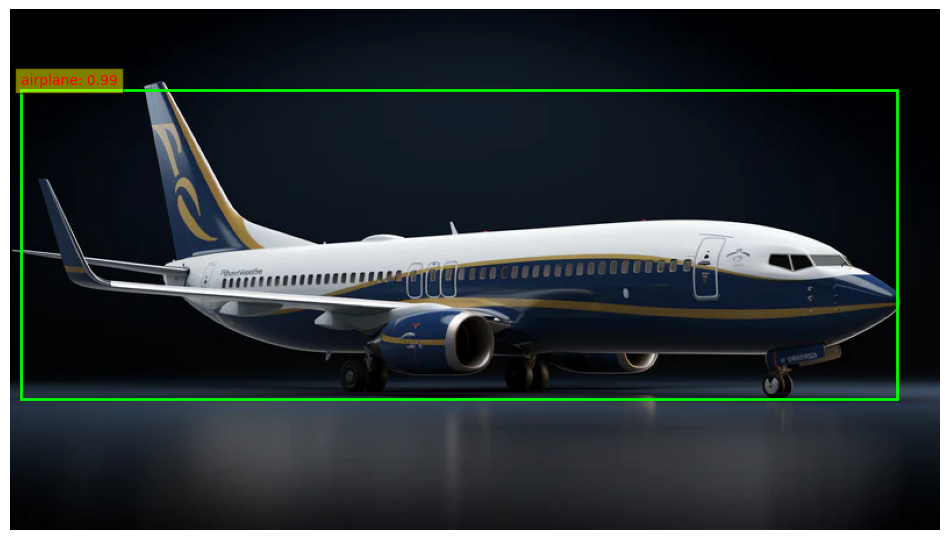

In [2]:
import os
import json
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from torchvision import models
from ipywidgets import widgets
from IPython.display import display
from matplotlib.patches import Rectangle

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
    'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
    'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def load_model(pretrained=True, device='cpu'):
    """Load and return a Faster R-CNN model."""
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)
    model.to(device)
    model.eval()
    return model

def detect_objects(image, model, device='cpu', confidence_threshold=0.5):
    """
    Detect objects in an image.

    Args:
        image: Path to the image file or a numpy array.
        model: Pre-trained object detection model.
        device: Device to run the model on ('cpu' or 'cuda').
        confidence_threshold: Minimum score for predictions to be considered valid.

    Returns:
        Predictions dictionary.
    """
    if isinstance(image, str):
        image = cv2.imread(image)
        if image is None:
            raise FileNotFoundError(f"Image at '{image}' not found or could not be opened.")
    elif isinstance(image, np.ndarray):
        pass
    else:
        raise ValueError("Input image must be a file path or a numpy array.")

    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        predictions = model(image_tensor)

    return predictions[0]

def export_to_json(predictions, output_path="detection_results.json"):
    """
    Export object detection results to a JSON file.

    Args:
        predictions: Predictions dictionary from the model.
        output_path: Path to save the JSON file.
    """
    export_data = {
        "boxes": predictions['boxes'].cpu().numpy().tolist(),
        "labels": [COCO_INSTANCE_CATEGORY_NAMES[label] for label in predictions['labels'].cpu().numpy()],
        "scores": predictions['scores'].cpu().numpy().tolist(),
    }

    with open(output_path, "w") as f:
        json.dump(export_data, f, indent=4)
    print(f"Detection results saved to: {output_path}")

def interactive_visualization(image, predictions, confidence_threshold=0.5):
    """
    Display an interactive visualization of detected objects using matplotlib.

    Args:
        image: Input image as a numpy array.
        predictions: Predictions dictionary from the model.
        confidence_threshold: Minimum score for predictions to be considered valid.
    """
    labels = predictions['labels'].cpu().numpy()
    scores = predictions['scores'].cpu().numpy()
    boxes = predictions['boxes'].cpu().numpy()

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image_rgb)
    ax.axis("off")

    for i, box in enumerate(boxes):
        if scores[i] >= confidence_threshold:
            label = COCO_INSTANCE_CATEGORY_NAMES[labels[i]]
            score = scores[i]
            rect = Rectangle(
                (box[0], box[1]),
                box[2] - box[0],
                box[3] - box[1],
                linewidth=2,
                edgecolor="lime",
                facecolor="none",
            )
            ax.add_patch(rect)
            ax.text(
                box[0],
                box[1] - 5,
                f"{label}: {score:.2f}",
                color="red",
                fontsize=10,
                bbox=dict(facecolor="yellow", alpha=0.5),
            )

    plt.show()

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = load_model(pretrained=True, device=device)

    image_path = "/content/boeing_737.jpeg"
    image = cv2.imread(image_path)

    predictions = detect_objects(image, model, device=device)

    export_to_json(predictions, output_path="detection_results.json")

    interactive_visualization(image, predictions, confidence_threshold=0.6)